#### Task 1: Produce datasets of hourly data at selected global cities 1979-2020.  
The cities are Los Angeles (USA), Mexico City (Mexico), London (UK), Paris (France), Cairo (Egypt), Sharm El-Sheikh (Egypt), Dubai, Manila (Philippines), and Sydney (Australia).(use the closest *land* grid point to these cities and avoid any ocean data points).

write to text files (or netcdf) for each location with columns:
 grid point lat, grid point lon, yyyymmddhh, 2m temperature, 2m dew-point temperature, 2m wet-bulb temperature, 10m U wind, 10m V wind

If you don't already have those additional variables then you can find them in here:
/glade/collections/rda/data/ds633.0/e5.oper.an.sfc/

I will do some additional analysis with the data you produce.

#### Task 2:  
For each of the 9 cities, use the hourly 2m wet-bulb temperature timeseries data from Task 1 and convert to daily maximum value of 2m wet-bulb temperature.
Convert the time series to binary (1=.ge.28; 0=.lt.28). Then count the number of times we get *consecutive sequences* of value=1. If we have any zero values between values of 1 then we count them as separate sequences.
Then for each sequence we need to calculate some characteristics. These characteristics are i) duration (days), ii) max value of wet-bulb temperature over the sequence, and iii) start date.

In [1]:
import os.path
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage 
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import datetime
import glob
import geopy
from geopy.geocoders import Nominatim

In [2]:
def plot_9city(flnm):
    # use first column as index
    df_d = pd.read_csv(flnm, index_col = 0)
    # Converting the index as date
    date_s = pd.to_datetime(df_d.index)
    yyyymmddhh = date_s.format(formatter=lambda x: x.strftime('%Y%m%d%H'))
    df_d.index = yyyymmddhh
    df_d.plot(figsize=(20, 10))

def format_9city_csv(flnm_i, flnm_o):
    # first column as index
    df_t = pd.read_csv(flnm_i, index_col = 0)
    # Converting the index as date
    date_s = pd.to_datetime(df_t.index)
    yyyymmddhh = date_s.format(formatter=lambda x: x.strftime('%Y%m%d%H'))
    df_t.index = yyyymmddhh
    
    # Round each number in a Python pandas data frame by 2 decimals
    df_t.round(2)
    df_t.round(2).to_csv(flnm_o) 

def consecutive(x, thresh = 1, cum_type = 'cdd'):
    count = 0
    overall_counter = []
    i = 0
    while i < len(x):
        
        if cum_type == 'cdd':
            # Consecutive Dry Days
            if x[i] < thresh:
                count+=1
                if i == len(x) - 1:
                    overall_counter.append(count)
            else:
                overall_counter.append(count)
                count = 0
        elif cum_type == 'cwd':
            # Consecutive Wet Days
            if x[i] >= thresh:
                count+=1
                if i == len(x) - 1:
                    overall_counter.append(count)
            else:
                overall_counter.append(count)
                count = 0
        
        i+=1
    return max(overall_counter)
    
RR = [1,2,1,1,1,3,2,4,1,1,1,1,1,3,0,0,0,0,0,0.3,0.5,1,0,0,0.8,23]
consecutive(RR, 1, cum_type = 'cdd')


7

#### check mask

'/glade/collections/rda/data/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'

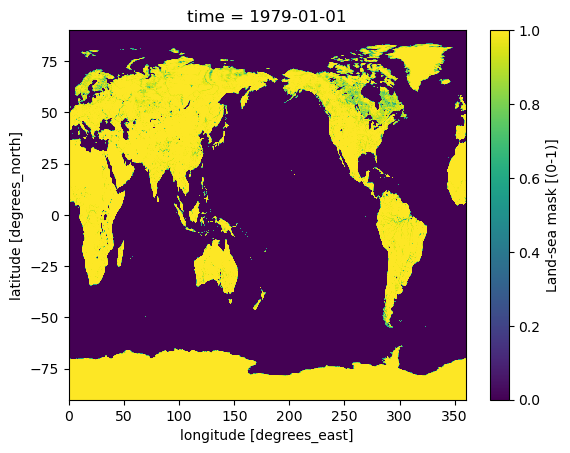

In [3]:
proj = ccrs.PlateCarree()

flnm_mask = '/glade/collections/rda/data/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'
with  xr.open_dataset(flnm_mask) as ds:
        lsm = ds['LSM']
        lsm =lsm.where(lsm>0.5).fillna(0)[0]

lsm.plot()
flnm_mask

#### get location of cities and make sure they are >.5 fraction over land

In [4]:
# Create a geolocator object using the Openstreet Nominatim API. 
# It’s a good idea to increase the default timeout setting from 1s to 10s 
# so that you don’t get a TimedOut exception. 
# You’ll also need to enter a name (any name) for the ‘user_agent’ attribute.
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")

# locatins of  Los Angeles (USA), Mexico City (Mexico), London (UK), Paris (France), Cairo (Egypt), Sharm El-Sheikh (Egypt), Dubai, Manila (Philippines), and Sydney (Australia).
city_s = ['Los Angeles', 'Mexico City', 'London', 'Paris', 'Cairo', 'Sharm EL-Sheikh', 'Dubai', 'Manila', 'Sydney' ]
country_s = ['US', 'Mexico', 'UK', 'France', 'Egypt', 'Egypt','UAE', 'Philippines', 'Australia' ]
n_city = len(city_s)

lat_1d = []
lon_1d = []

for nc  in range(n_city):
    city = city_s[nc]
    country = country_s[nc]
    loc = geolocator.geocode(city + ','+ country)
     
    print(nc,city, country, "latitude: " ,loc.latitude, " longtitude: " ,loc.longitude)

    # move (27.8644422, 34.295447)  to (27.9654, 34.3618)
    if city == 'Sharm EL-Sheikh':
        lat_1d.append(27.9654)
        lon_1d.append(34.3618)
    #  move 151.2082848 -> 151.12   
    elif city == 'Sydney':
        lat_1d.append(loc.latitude)
        lon_1d.append(151.12)
    else:
        lat_1d.append(loc.latitude) 
        if loc.longitude < 0:
            lon_1d.append(360. + loc.longitude)
        else:
            lon_1d.append(loc.longitude) 
    print(city, lat_1d[nc], lon_1d[nc])     

0 Los Angeles US latitude:  34.0536909  longtitude:  -118.242766
Los Angeles 34.0536909 241.75723399999998
1 Mexico City Mexico latitude:  19.4326296  longtitude:  -99.1331785
Mexico City 19.4326296 260.8668215
2 London UK latitude:  51.5073219  longtitude:  -0.1276474
London 51.5073219 359.8723526
3 Paris France latitude:  48.8588897  longtitude:  2.3200410217200766
Paris 48.8588897 2.3200410217200766
4 Cairo Egypt latitude:  30.0443879  longtitude:  31.2357257
Cairo 30.0443879 31.2357257
5 Sharm EL-Sheikh Egypt latitude:  27.8644422  longtitude:  34.295447
Sharm EL-Sheikh 27.9654 34.3618
6 Dubai UAE latitude:  25.074282349999997  longtitude:  55.18853865430702
Dubai 25.074282349999997 55.18853865430702
7 Manila Philippines latitude:  14.5948914  longtitude:  120.9782618
Manila 14.5948914 120.9782618
8 Sydney Australia latitude:  -33.8698439  longtitude:  151.2082848
Sydney -33.8698439 151.12


In [5]:
flnm_mask = '/glade/collections/rda/data/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'
with  xr.open_dataset(flnm_mask) as ds:
    lsm = ds['LSM']
    lsm =lsm.where(lsm>0.5) #.fillna(0)[0]
    
    # make sure they are over land
    for nc in range(n_city):
        print(city_s[nc], 'lsm', lsm.sel(latitude=lat_1d[nc], longitude=lon_1d[nc], method="nearest").values
             , 'lat', lat_1d[nc],'lon',lon_1d[nc])
        

Los Angeles lsm [0.95556843] lat 34.0536909 lon 241.75723399999998
Mexico City lsm [0.9943254] lat 19.4326296 lon 260.8668215
London lsm [0.98467004] lat 51.5073219 lon 359.8723526
Paris lsm [0.99557924] lat 48.8588897 lon 2.3200410217200766
Cairo lsm [0.97676337] lat 30.0443879 lon 31.2357257
Sharm EL-Sheikh lsm [0.73332906] lat 27.9654 lon 34.3618
Dubai lsm [0.85981596] lat 25.074282349999997 lon 55.18853865430702
Manila lsm [0.51897335] lat 14.5948914 lon 120.9782618
Sydney lsm [0.96434116] lat -33.8698439 lon 151.12


#### extract time series over those cities 

In [6]:
# hourly variables
var_f = ['2t', '2d','10u', '10v']
var_s = ['VAR_2T', 'VAR_2D', 'VAR_10U', 'VAR_10V']
var_f = ['2t']
var_s = ['VAR_2T']

n_var = len(var_s) 

dir_i = '/glade/collections/rda/data/ds633.0/e5.oper.an.sfc/'

In [7]:
year_s = 1979
year_e = 2020
#year_e = year_s + 1

StartDay = datetime.datetime(year_s, 1, 1, 0)
StopDay  = datetime.datetime(year_e, 12, 31, 23)
TimeHH = pd.date_range(StartDay, end=StopDay, freq='1h')
print('n_hours:', len(TimeHH), ' between', StartDay, 'and', StopDay)

    
#for nv in range(1):    
for nv in range(len(var_f)):
    flnm_o = 'DATA/' + var_f[nv] + '.csv'
    if os.path.exists(flnm_o): 
        print(flnm_o, 'exist')
        continue
    var_new = np.zeros((n_city))
    var_new = var_new [None,:]
    for year in range(year_s, year_e + 1):
        for month in range(1,12+1):
            print(year, month, var_f[nv])
            
            FILE = glob.glob(dir_i + str(year) + str(month).zfill(2) + '/*_' + var_f[nv] + '*.nc')[0]
            
            with xr.open_dataset(FILE) as ds:
                print('FILE=', FILE)
                
                var_3d = ds[var_s[nv]]
                 
                var_2d = np.zeros((var_3d.shape[0],n_city)) 
                
                for nc in range(n_city):
                    val_1d = var_3d.sel(latitude=lat_1d[nc], longitude=lon_1d[nc], method="nearest").values
                    #print(len(val_1d))
                    var_2d[:,nc] = val_1d              
                var_new = np.append(var_new, var_2d, axis=0)
    df = pd.DataFrame(var_new[1:], columns = city_s)
    df = df.set_index(TimeHH)
    df.plot(title=var_s[nv])
    df.to_csv(flnm_o)  
print('SUCCEED')

n_hours: 368184  between 1979-01-01 00:00:00 and 2020-12-31 23:00:00
DATA/2t.csv exist
SUCCEED


##### formate csv file for James

In [10]:
format_9city_csv('/glade/u/home/mingge/HEAT/DATA/2t.csv', '/glade/u/home/mingge/HEAT/2t.csv')
format_9city_csv('/glade/u/home/mingge/HEAT/DATA/2d.csv', '/glade/u/home/mingge/HEAT/2d.csv')
format_9city_csv('/glade/u/home/mingge/HEAT/DATA/10u.csv', '/glade/u/home/mingge/HEAT/10u.csv')
format_9city_csv('/glade/u/home/mingge/HEAT/DATA/10v.csv', '/glade/u/home/mingge/HEAT/10v.csv')

In [3]:
format_9city_csv('/glade/u/home/mingge/HEAT/DATA/twb.csv', '/glade/u/home/mingge/HEAT/twb.csv')

#### Plot for verification

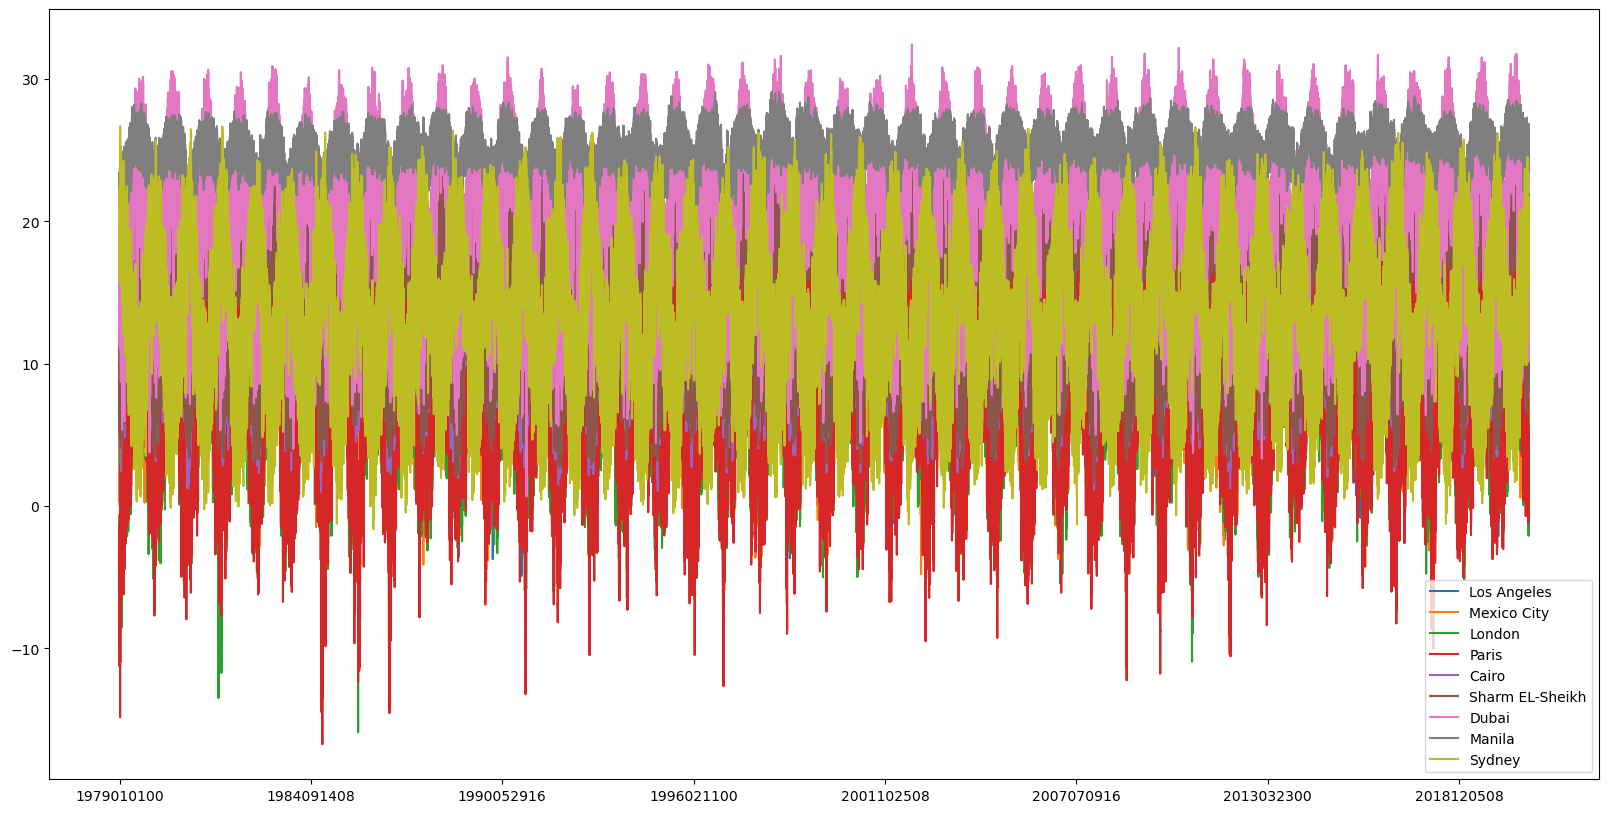

In [4]:
plot_9city('/glade/u/home/mingge/HEAT/DATA/twb.csv')

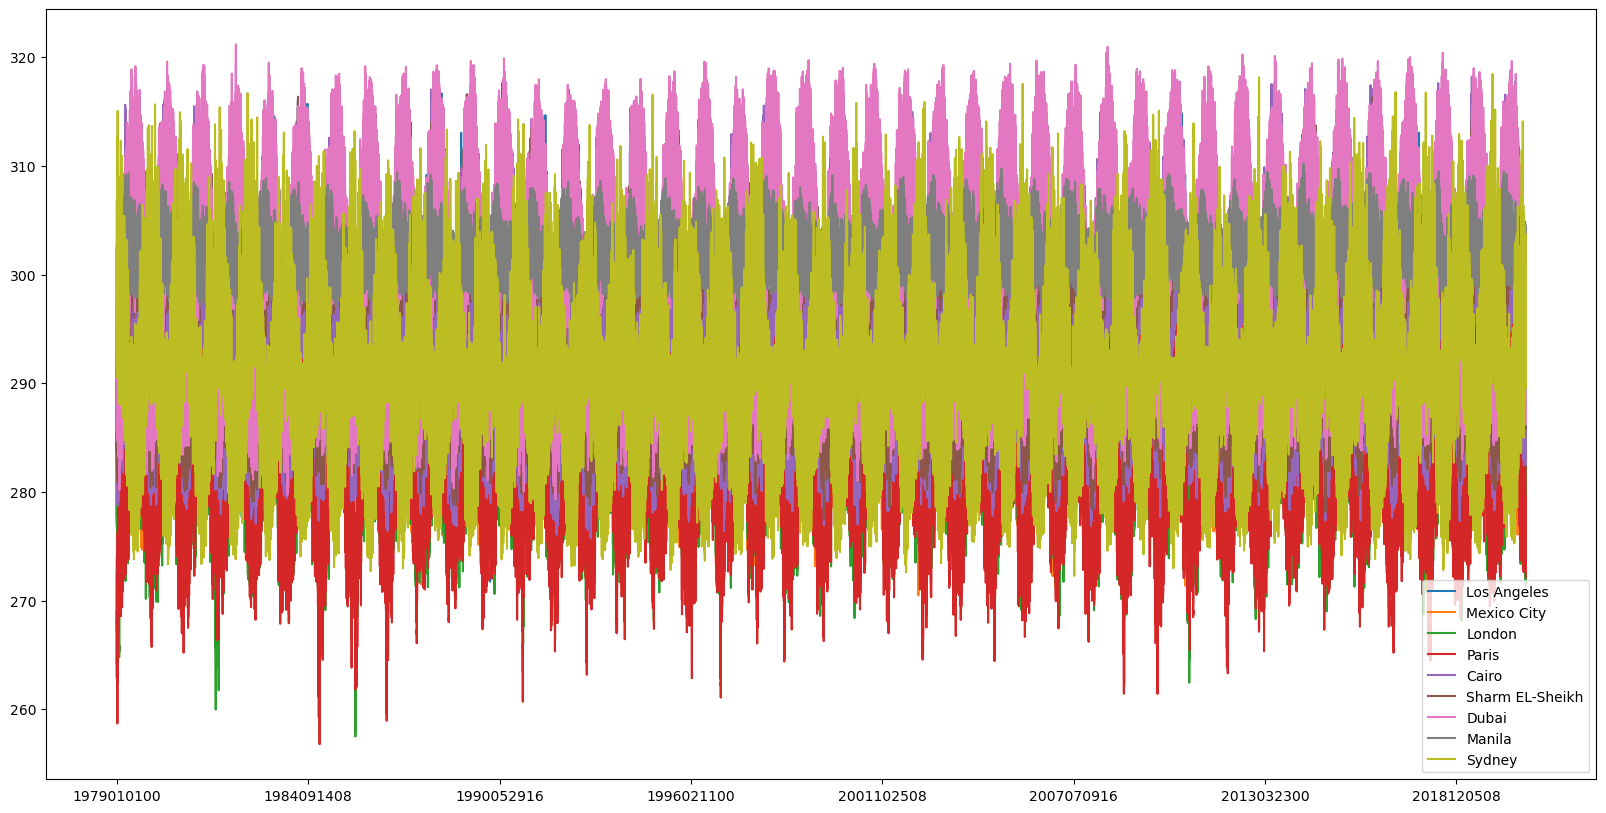

In [15]:
plot_9city('/glade/u/home/mingge/HEAT/DATA/2t.csv')

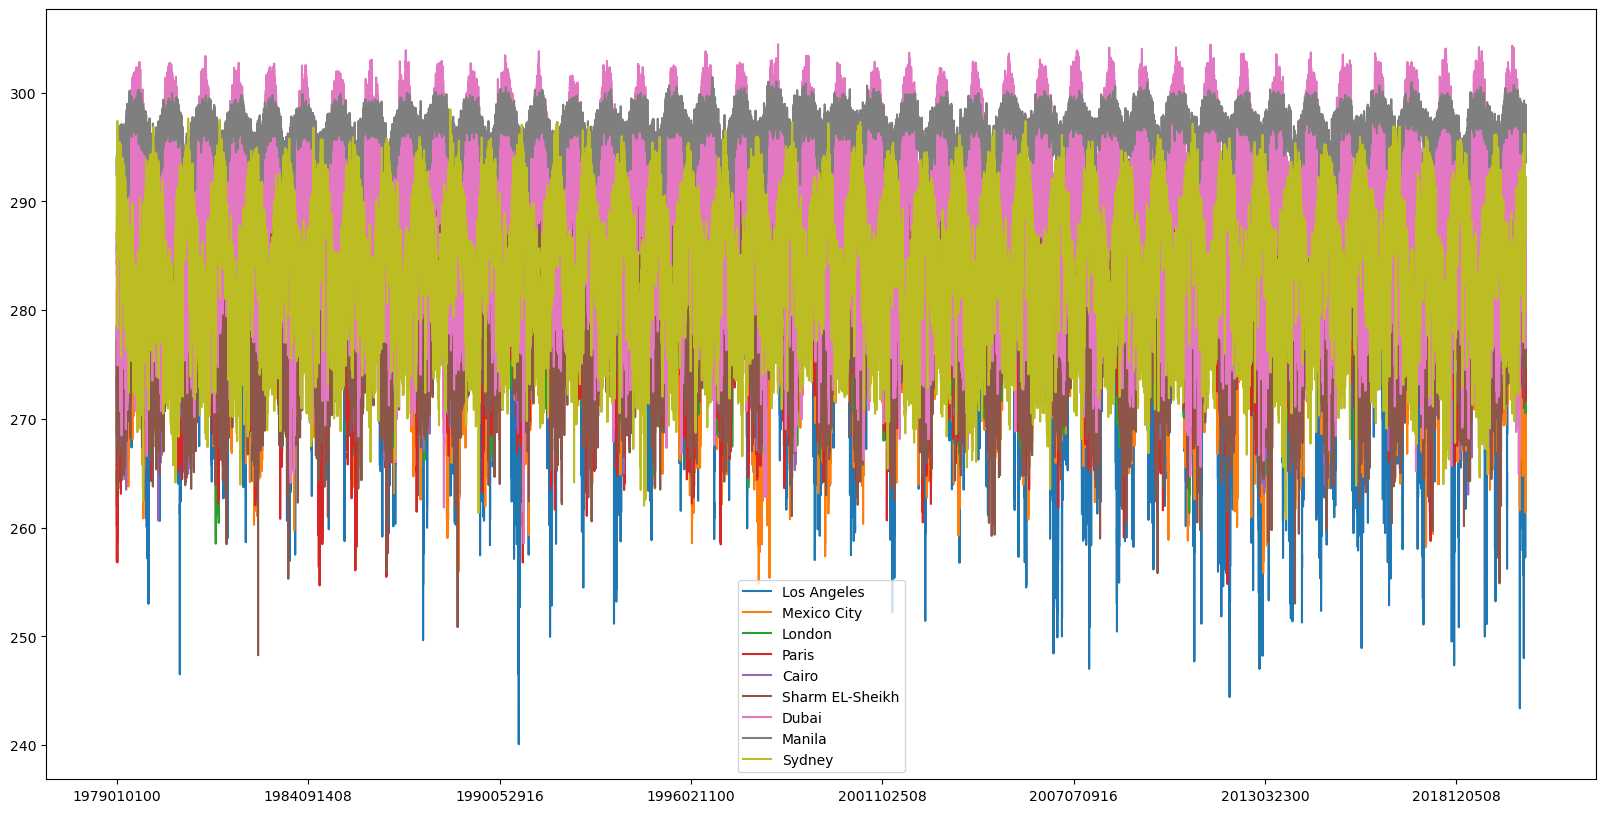

In [16]:
plot_9city('/glade/u/home/mingge/HEAT/DATA/2d.csv')

RangeIndex(start=0, stop=368184, step=1)

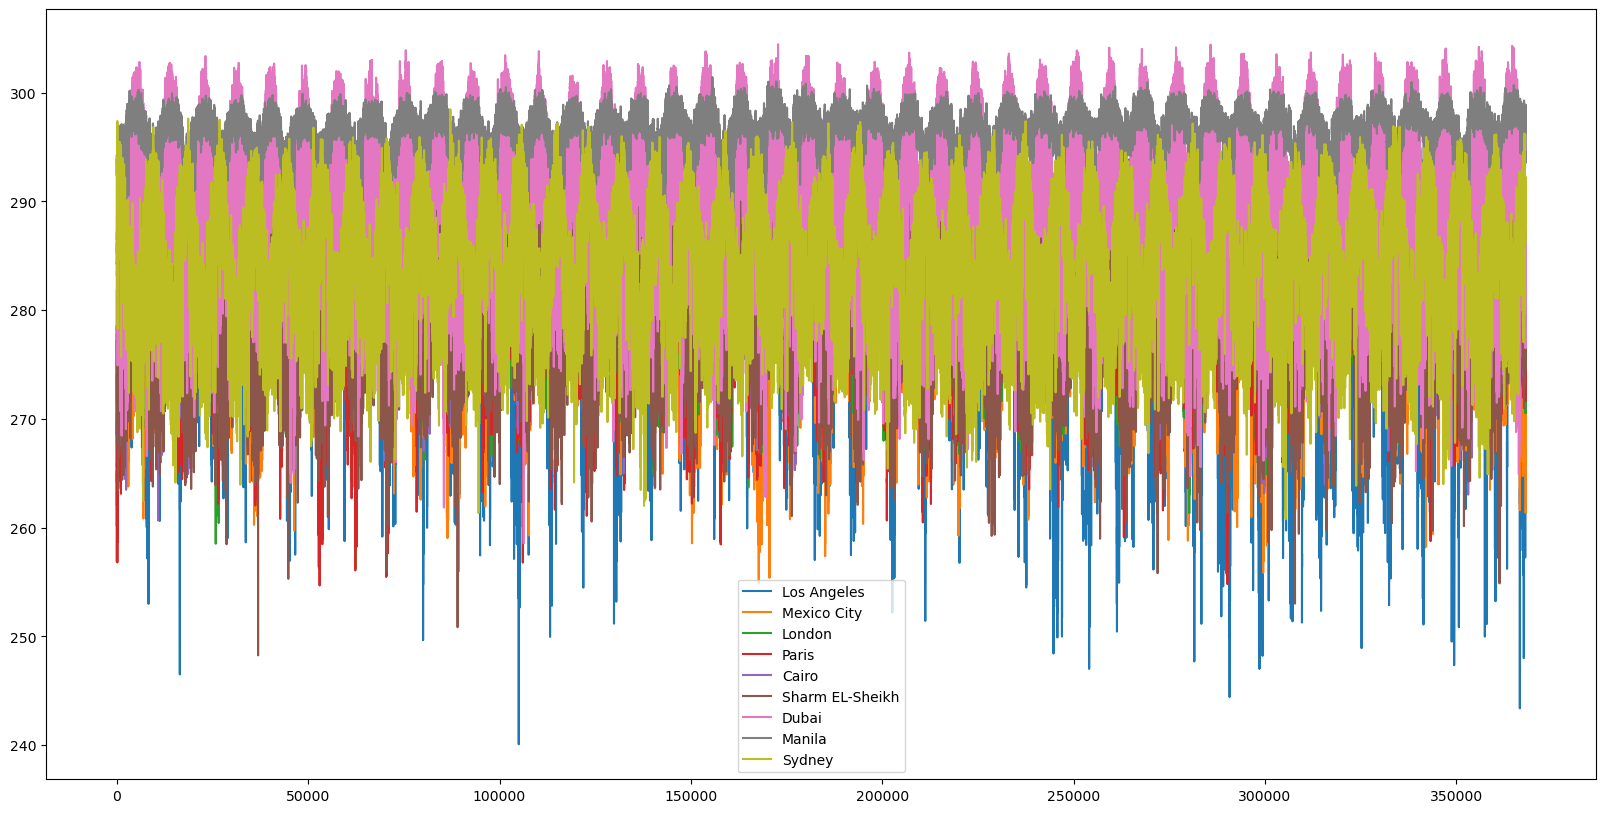

In [14]:
#plot_9city_new('/glade/u/home/mingge/HEAT/2t.csv')
flnm = '/glade/u/home/mingge/HEAT/2d.csv'
df_d = pd.read_csv(flnm, index_col = 0)
   
# Drop a Pandas Dataframe index with `.reset_index()
df_d = df_d.reset_index(drop=True)
df_d.plot(figsize=(20, 10))
df_d.index

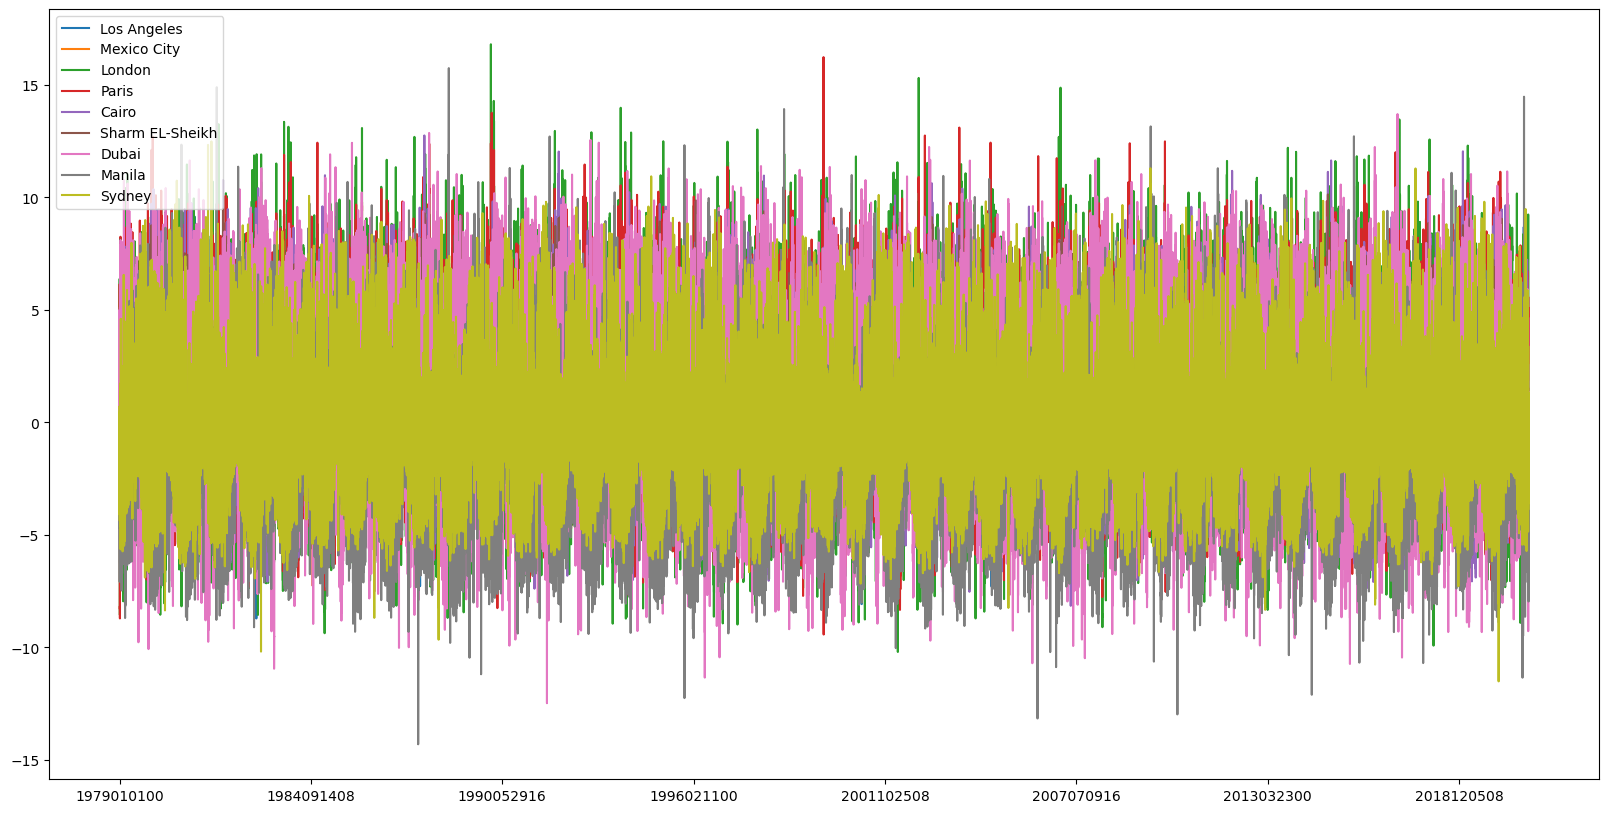

In [17]:
plot_9city('/glade/u/home/mingge/HEAT/DATA/10u.csv')

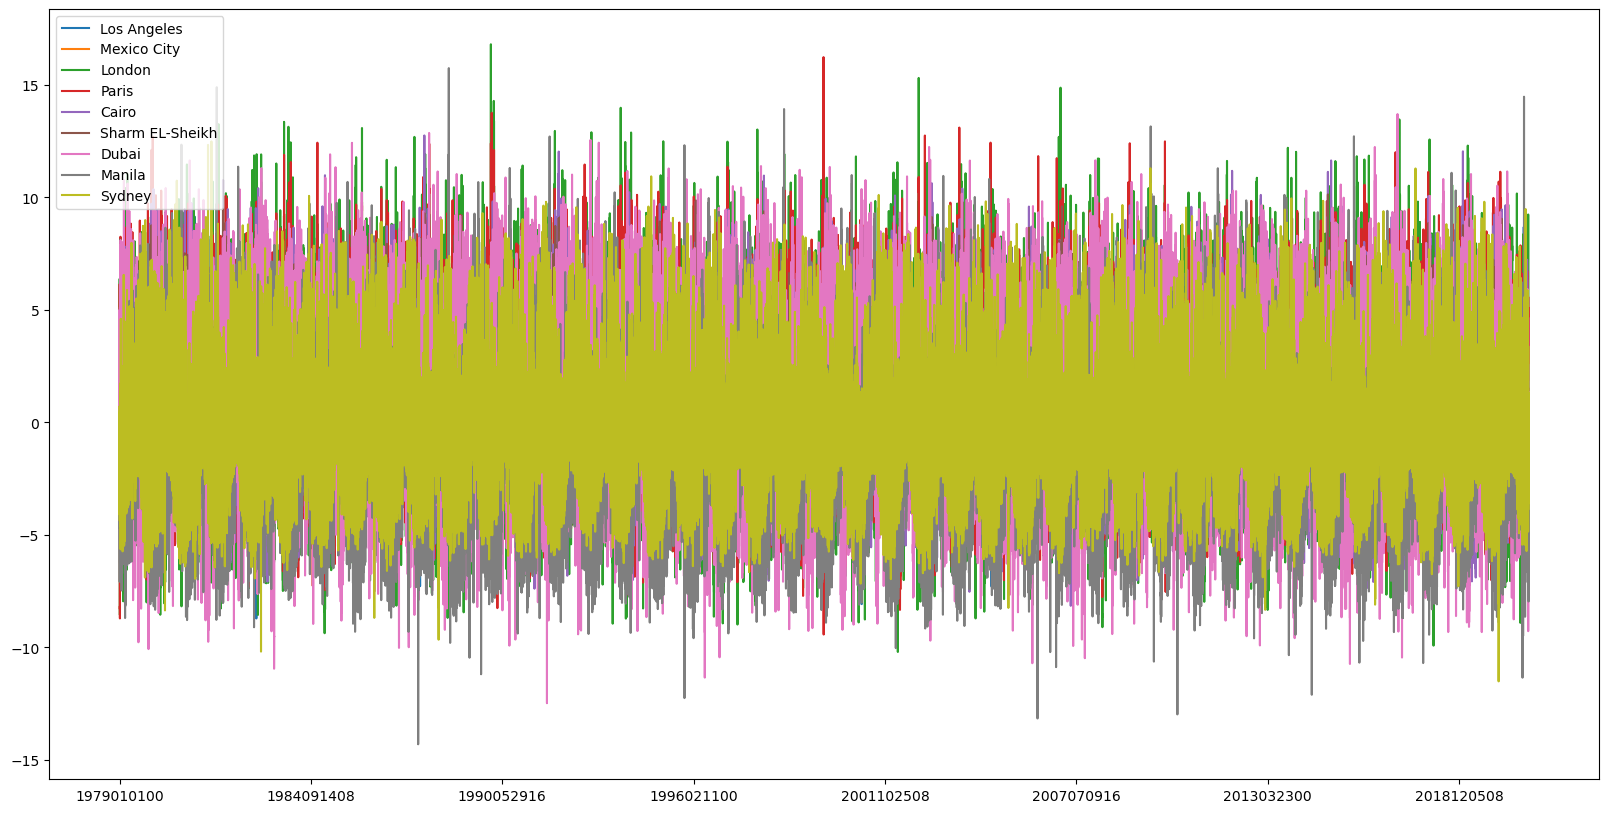

In [18]:
plot_9city('/glade/u/home/mingge/HEAT/DATA/10u.csv')

#### The average (over 42 years) of the annual maximum of the daily maxima  

In [11]:
dir_i = '/glade/campaign/mmm/c3we/mingge/wetbulb/daily_max/'
year_s = 1979
year_e = 2020
 
n_year = year_e - year_s + 1
n_month = 12

n_lat = 721
n_lon = 1440

flnm_o = dir_i + 'TWB_' + str(year_s) + '-' + str(year_e) + '_annual_max.nc' 


if not os.path.exists(flnm_o): 
    # get annual maxima of daily maxima
    for year in range(year_s, year_e + 1):
        for month in range(1, n_month+1, 1):
            flnm_i = dir_i + 'TWB_' + str(year) + str(month).zfill(2) + '_dailyMax.nc'
            print(flnm_i)
            with xr.open_dataset(flnm_i) as ds:
                twb = ds['TWB'].max(dim='dayofyear')
            if month == 1:
                twb_0 = twb 
            else:
                twb_3d = xr.concat([twb_0, twb], "month")
                twb_0 = twb_3d
            
        twb_max = twb_3d.max(dim='month') 
        if year == year_s:
            twb_1 = twb_max
        else:
            twb_3d = xr.concat([twb_1, twb_max], "year")
            twb_1 = twb_3d
     
    twb_3d.to_netcdf(flnm_o)
else:
    with xr.open_dataset(flnm_o) as ds:
        twb_3d = ds['TWB']


In [ ]:
def consecutive_max(arr_1d, threshold):
    PR_bin = arr_1d > threshold

    # Label features in an array. It returns label and the number of obj
    PR_label, n_obj = (ndimage.label(PR_bin)) 

    # Find objects in a labeled array. It returns a list of tuples,with each tuple containing N slices 
    #  (with N the dimension of the input array, 1 here)
    # correspond to the minimal parallelepiped that contains the object.
    obj_ind = ndimage.find_objects(PR_label)    
    obj_len = np.array([obj_ind[obj][0].stop - obj_ind[obj][0].start for obj in range(n_obj)])
    #print(obj_len)
    #print(type(obj_len))
    #print(max(obj_len))
    return max(obj_len)